<a href="https://colab.research.google.com/github/arkajyotimitra/mini_projects/blob/main/vaemnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.655273
Train Epoch: 1 [12800/60000 (21%)]	Loss: 192.057632
Train Epoch: 1 [25600/60000 (43%)]	Loss: 177.016251
Train Epoch: 1 [38400/60000 (64%)]	Loss: 166.276428
Train Epoch: 1 [51200/60000 (85%)]	Loss: 166.641983
====> Epoch: 1 Average loss: 182.8479
Train Epoch: 2 [0/60000 (0%)]	Loss: 169.009338
Train Epoch: 2 [12800/60000 (21%)]	Loss: 165.625534
Train Epoch: 2 [25600/60000 (43%)]	Loss: 158.049667
Train Epoch: 2 [38400/60000 (64%)]	Loss: 165.613495
Train Epoch: 2 [51200/60000 (85%)]	Loss: 159.486588
====> Epoch: 2 Average loss: 159.9155
Train Epoch: 3 [0/60000 (0%)]	Loss: 159.621094
Train Epoch: 3 [12800/60000 (21%)]	Loss: 154.703781
Train Epoch: 3 [25600/60000 (43%)]	Loss: 163.160797
Train Epoch: 3 [38400/60000 (64%)]	Loss: 150.950287
Train Epoch: 3 [51200/60000 (85%)]	Loss: 154.810394
====> Epoch: 3 Average loss: 154.1295
Train Epoch: 4 [0/60000 (0%)]	Loss: 162.222214
Train Epoch: 4 [12800/60000 (21%)]	Loss: 159.559372
Train Epoch: 4 [25600/

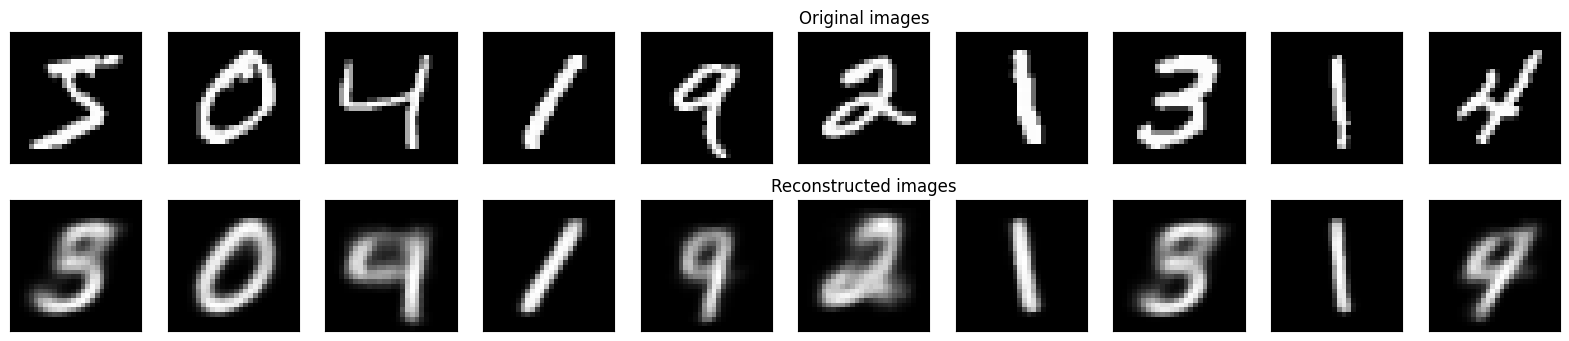

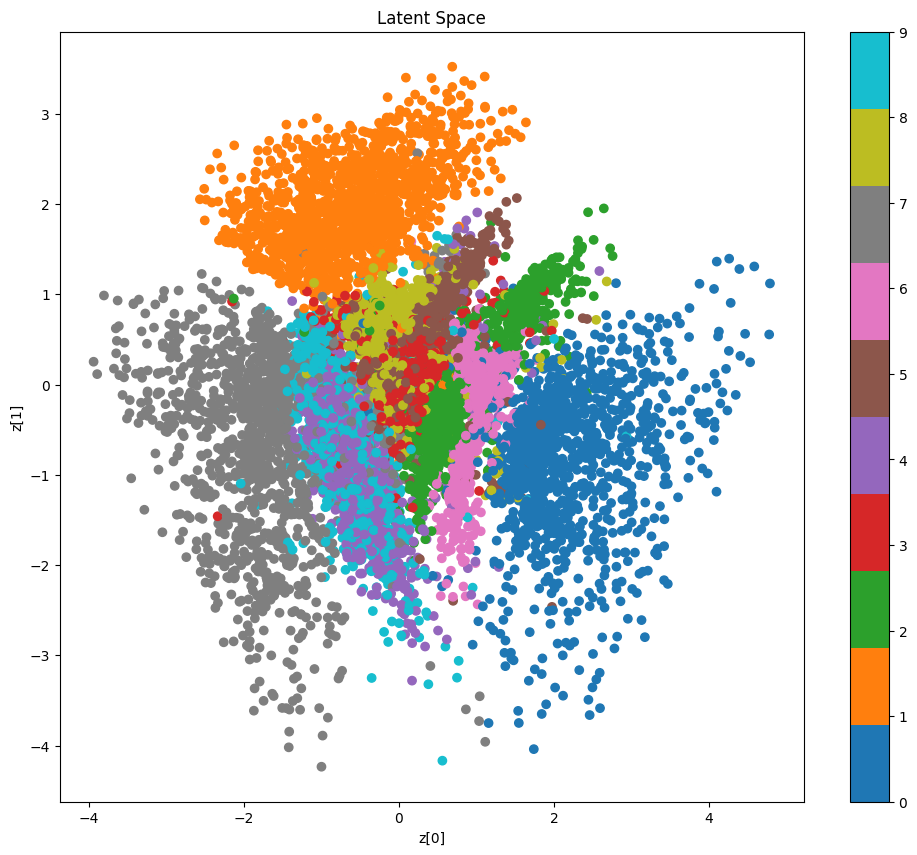

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# VAE Model (same as before)
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function (same as before)
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function (same as before)
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Visualization functions
def plot_reconstructed(model, device, dataset, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        img = dataset[i][0].unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            rec, _, _ = model(img)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(rec.cpu().squeeze().numpy().reshape(28,28), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()

def plot_latent(model, device, dataset, num_batches=100):
    plt.figure(figsize=(12, 10))
    model.eval()
    for i, (x, y) in enumerate(dataset):
        if i >= num_batches:
            break
        x = x.to(device)
        with torch.no_grad():
            mu, _ = model.encode(x.view(-1, 784))
        z = mu.cpu().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
    plt.colorbar()
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.title('Latent Space')
    plt.show()

# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # MNIST Dataset
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    model = VAE(input_dim=784, hidden_dim=400, latent_dim=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training
    for epoch in range(1, 11):  # Increased epochs for better results
        train(model, device, train_loader, optimizer, epoch)

    # Visualizations
    plot_reconstructed(model, device, train_dataset)
    plot_latent(model, device, train_loader)

if __name__ == '__main__':
    main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 542.992554
Train Epoch: 1 [12800/60000 (21%)]	Loss: 190.440018
Train Epoch: 1 [25600/60000 (43%)]	Loss: 162.790909
Train Epoch: 1 [38400/60000 (64%)]	Loss: 161.478775
Train Epoch: 1 [51200/60000 (85%)]	Loss: 158.647339
====> Epoch: 1 Average loss: 180.4222
Train Epoch: 2 [0/60000 (0%)]	Loss: 163.784760
Train Epoch: 2 [12800/60000 (21%)]	Loss: 157.571793
Train Epoch: 2 [25600/60000 (43%)]	Loss: 147.958221
Train Epoch: 2 [38400/60000 (64%)]	Loss: 159.092743
Train Epoch: 2 [51200/60000 (85%)]	Loss: 154.186356
====> Epoch: 2 Average loss: 155.0956
Train Epoch: 3 [0/60000 (0%)]	Loss: 150.843262
Train Epoch: 3 [12800/60000 (21%)]	Loss: 148.432068
Train Epoch: 3 [25600/60000 (43%)]	Loss: 151.395477
Train Epoch: 3 [38400/60000 (64%)]	Loss: 150.907211
Train Epoch: 3 [51200/60000 (85%)]	Loss: 151.399918
====> Epoch: 3 Average loss: 149.4774
Train Epoch: 4 [0/60000 (0%)]	Loss: 146.893799
Train Epoch: 4 [12800/60000 (21%)]	Loss: 145.946564
Train Epoch: 4 [25600/

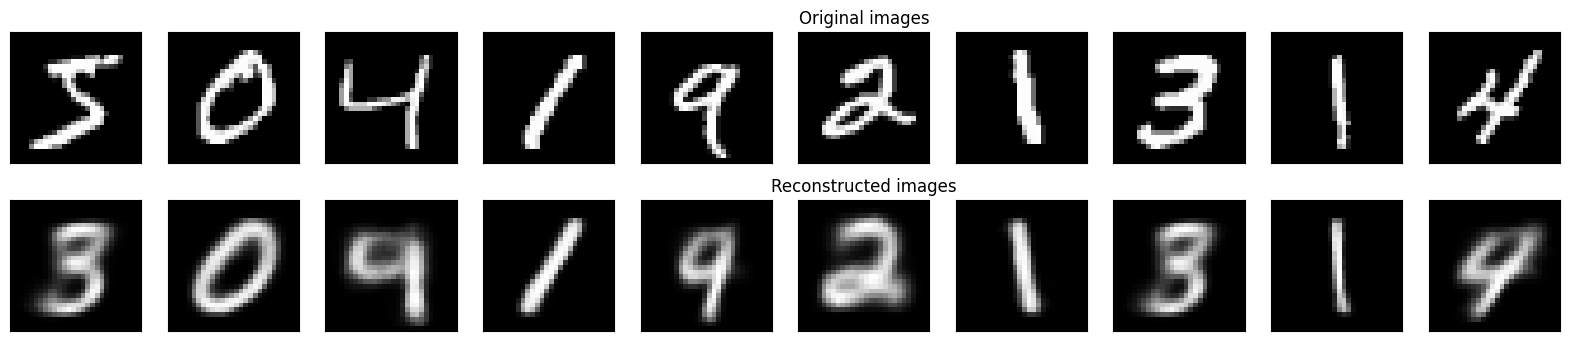

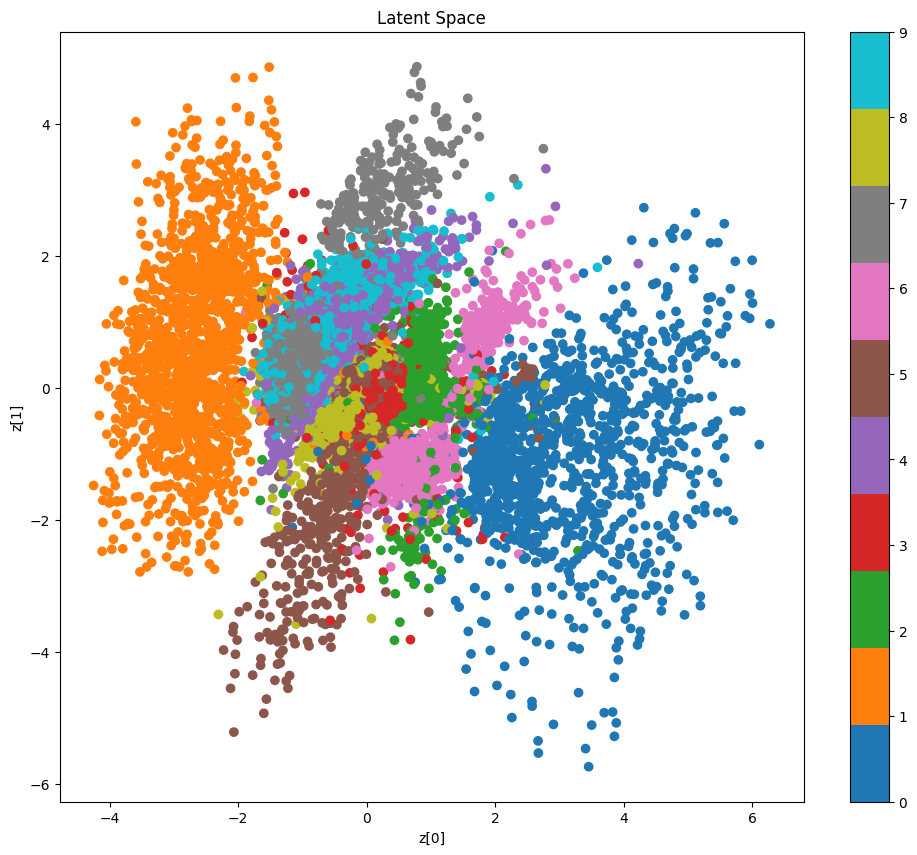

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# VAE Model (same as before)
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function (same as before)
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # adding a beta value and making it beta-VAE, usually beta > 1 is helpful, empirically i am seeing less than is more useful!
    # seems like the more i increase the value..the latent space is shrinked further
    beta = 0.3
    return BCE + beta * KLD

# Training function (same as before)
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Visualization functions
def plot_reconstructed(model, device, dataset, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        img = dataset[i][0].unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            rec, _, _ = model(img)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(rec.cpu().squeeze().numpy().reshape(28,28), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()

def plot_latent(model, device, dataset, num_batches=100):
    plt.figure(figsize=(12, 10))
    model.eval()
    for i, (x, y) in enumerate(dataset):
        if i >= num_batches:
            break
        x = x.to(device)
        with torch.no_grad():
            mu, _ = model.encode(x.view(-1, 784))
        z = mu.cpu().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
    plt.colorbar()
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.title('Latent Space')
    plt.show()

# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # MNIST Dataset
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    model = VAE(input_dim=784, hidden_dim=400, latent_dim=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training
    for epoch in range(1, 11):  # Increased epochs for better results
        train(model, device, train_loader, optimizer, epoch)

    # Visualizations
    plot_reconstructed(model, device, train_dataset)
    plot_latent(model, device, train_loader)

if __name__ == '__main__':
    main()